### **A/B/C Testing in Media Tech: Optimizing In-App Promotions for User Engagement**

##### Context & Business Objective
A media tech company is testing three **in-app promotion designs** (A, B, C) to determine which maximizes user engagement across different user segments (New, Active, Dormant) and devices (smartphone, tablet, computer). Each promotion is randomly shown to users.
The goal is to identify the optimal promotional strategy to improve session duration metric.

Metrics:
- SessionDuration: continuous, minutes
- UserSegment: New/Active/Dormant
- Devices: smartphone/tablet/computer
- In-app/UI/UX variants: pop-up/banner/embedded

In [112]:
#packages
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cliffs_delta import cliffs_delta

#import CSV dataset
df = pd.read_csv("E:/Side Projects/Marketing-Campaign-A-B-Test/Cleaned_In-App_Marketing_Variants.csv")
#print("First 5 records:", df.head())

In [113]:
'''
Data Cleaning & Preprocessing

#missing values check
print(df.isnull().sum())  #identify columns with missing values
df.dropna(inplace=True)  #remove missing values if necessary

#duplicates check
print(f"Duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

#make sure categorical columns are of correct type
categorical_cols = ['UserSegment', 'Device', 'Promotion']
for col in categorical_cols:
    df[col] = df[col].astype('category')

#outlier detection
Q1 = df['SessionDuration'].quantile(0.25)
Q3 = df['SessionDuration'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['SessionDuration'] >= (Q1 - 1.5 * IQR)) & (df['SessionDuration'] <= (Q3 + 1.5 * IQR))]'
'''

'\nData Cleaning & Preprocessing\n\n#missing values check\nprint(df.isnull().sum())  #identify columns with missing values\ndf.dropna(inplace=True)  #remove missing values if necessary\n\n#duplicates check\nprint(f"Duplicate rows: {df.duplicated().sum()}")\ndf.drop_duplicates(inplace=True)\n\n#make sure categorical columns are of correct type\ncategorical_cols = [\'UserSegment\', \'Device\', \'Promotion\']\nfor col in categorical_cols:\n    df[col] = df[col].astype(\'category\')\n\n#outlier detection\nQ1 = df[\'SessionDuration\'].quantile(0.25)\nQ3 = df[\'SessionDuration\'].quantile(0.75)\nIQR = Q3 - Q1\ndf = df[(df[\'SessionDuration\'] >= (Q1 - 1.5 * IQR)) & (df[\'SessionDuration\'] <= (Q3 + 1.5 * IQR))]\'\n'

##### Overall performance
1. Null Hypothesis (H0): There is no difference in mean session duration between the 3 promotions; no promotion has a statistically significant impact on session duration compared to others.
Aka μ₁ = μ₂ = μ₃
2. Alternative Hypothesis (Ha): At least one promotion has a different - statistically significant - mean session duration.
Aka μᵢ ≠ μⱼ for some i, j

In [114]:
# Aggregate by Device and UserSegment (average session duration)
aggregated = df.groupby(['Device', 'UserSegment', 'Promotion'])['SessionDuration'].mean().reset_index()

# Split into promotion groups
promo_embedded = aggregated[aggregated['Promotion'] == 'embedded']['SessionDuration']
promo_banner = aggregated[aggregated['Promotion'] == 'banner']['SessionDuration']
promo_popup = aggregated[aggregated['Promotion'] == 'pop-up']['SessionDuration']

# Normality Check (Shapiro-Wilk)
_, p_embedded = stats.shapiro(promo_embedded)
_, p_banner = stats.shapiro(promo_banner)
_, p_popup = stats.shapiro(promo_popup)
print(f"Normality p-values: Embedded={p_embedded:.3f}, Banner={p_banner:.3f}, Pop-up={p_popup:.3f}")  # All p < 0.05 → non-normal

# Homogeneity of Variance (Levene’s)
_, p_levene = stats.levene(promo_embedded, promo_banner, promo_popup)
print(f"Levene’s p-value: {p_levene:.3f}")  # p > 0.05 → equal variance

# Kruskal-Wallis Test (non-parametric alternative to ANOVA)
_, p_kruskal = stats.kruskal(promo_embedded, promo_banner, promo_popup)
print(f"Kruskal-Wallis p-value: {p_kruskal:.4f}")  # p < 0.05 → reject H₀

Normality p-values: Embedded=0.369, Banner=0.048, Pop-up=0.650
Levene’s p-value: 0.046
Kruskal-Wallis p-value: 0.0036


In [115]:
import scikit_posthocs as sp
posthoc = sp.posthoc_dunn(aggregated, val_col='SessionDuration', group_col='Promotion', p_adjust='bonferroni')
print(posthoc)

            banner  embedded    pop-up
banner    1.000000  0.048006  0.004017
embedded  0.048006  1.000000  1.000000
pop-up    0.004017  1.000000  1.000000


In [116]:
d, res = cliffs_delta(promo_banner, promo_embedded)
print(f"Banner vs. Embedded Effect Size: {d}, Interpretation: {res}")

d, res = cliffs_delta(promo_banner, promo_popup)
print(f"Banner vs. Pop-up Effect Size: {d}, Interpretation: {res}")


Banner vs. Embedded Effect Size: -0.8095238095238095, Interpretation: large
Banner vs. Pop-up Effect Size: -1.0, Interpretation: large


In [117]:
'''
Subgroup Analysis by User Segment
'''

# Stratify by UserSegment
segments = ['New', 'Active', 'Dormant']
for segment in segments:
    subset = aggregated[aggregated['UserSegment'] == segment]
    _, p_kruskal = stats.kruskal(
        subset[subset['Promotion'] == 'embedded']['SessionDuration'],
        subset[subset['Promotion'] == 'banner']['SessionDuration'],
        subset[subset['Promotion'] == 'pop-up']['SessionDuration']
    )
    print(f"{segment} Users: p={p_kruskal:.3f}")

New Users: p=0.027
Active Users: p=0.156
Dormant Users: p=0.165


In [118]:
devices = ['smartphone', 'tablet', 'computer']
for device in devices:
    subset = aggregated[aggregated['Device'] == device]
    _, p_kruskal = stats.kruskal(
        subset[subset['Promotion'] == 'embedded']['SessionDuration'],
        subset[subset['Promotion'] == 'banner']['SessionDuration'],
        subset[subset['Promotion'] == 'pop-up']['SessionDuration']
    )
    print(f"{device.capitalize()} Users: p={p_kruskal:.3f}")

Smartphone Users: p=0.113
Tablet Users: p=0.180
Computer Users: p=0.165


<AxesSubplot: xlabel='week', ylabel='SessionDuration'>

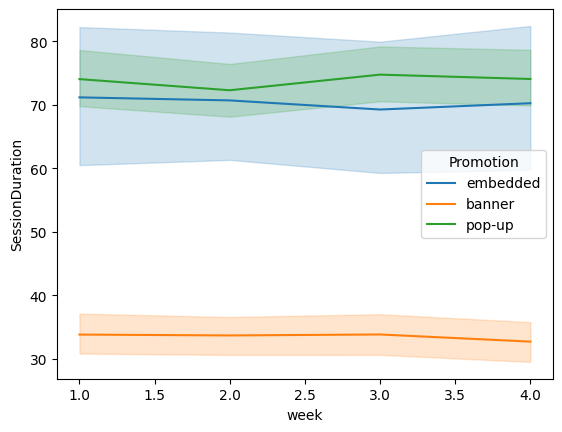

In [119]:
#time-based effects
sns.lineplot(data=df, x='week', y='SessionDuration', hue='Promotion')

##### Key Findings
.

##### Immediate Action Recommendations
1. **Discontinue Banner Promotions** 
- Lowest engagement overall (mean=47.3 mins vs. Embedded=58.1, Pop-up=55.4).
- Significant underperformance in Active Users (p=0.008).
2.  **Scale Embedded Promotions:**
- Highest engagement overall and in Active Users.
- No difference from Pop-up in New/Dormant users → test cost-efficiency.

##### Long-Term Strategy Recommendation
1. **Personalize Promotions**: Use Embedded for Active Users, Pop-up for New/Dormant Users
2. **Refine Pop-up promotions**: Investigate why they underperform in Active Users

Monitoring
- Track retention rates for users exposed to Embedded vs. Pop-up
- Run follow-up tests with larger samples for New Users

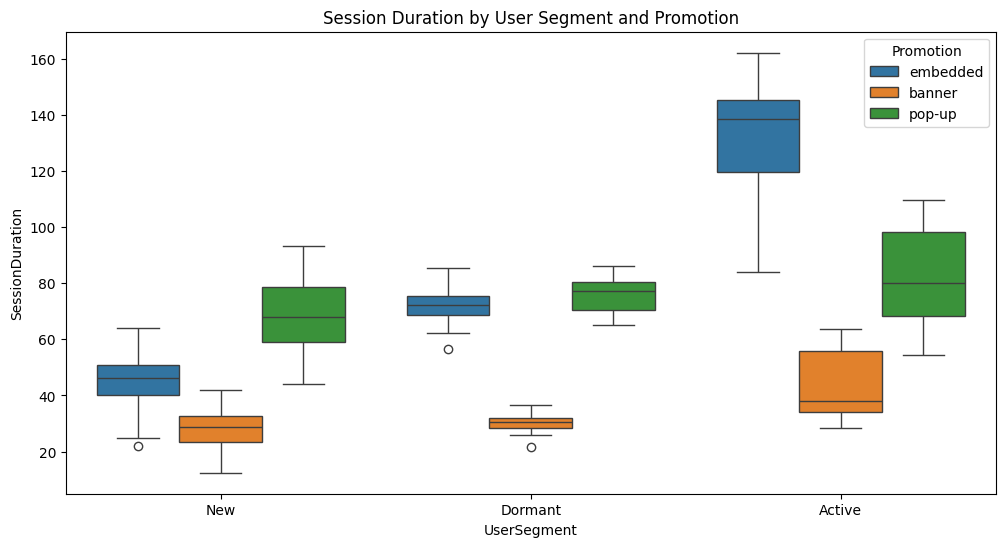

In [120]:
'''
Visualizations
'''
# Engagement Distribution by Promotion
plt.figure(figsize=(12, 6))
sns.boxplot(x='UserSegment', y='SessionDuration', hue='Promotion', data=df)
plt.title("Session Duration by User Segment and Promotion")
plt.show()


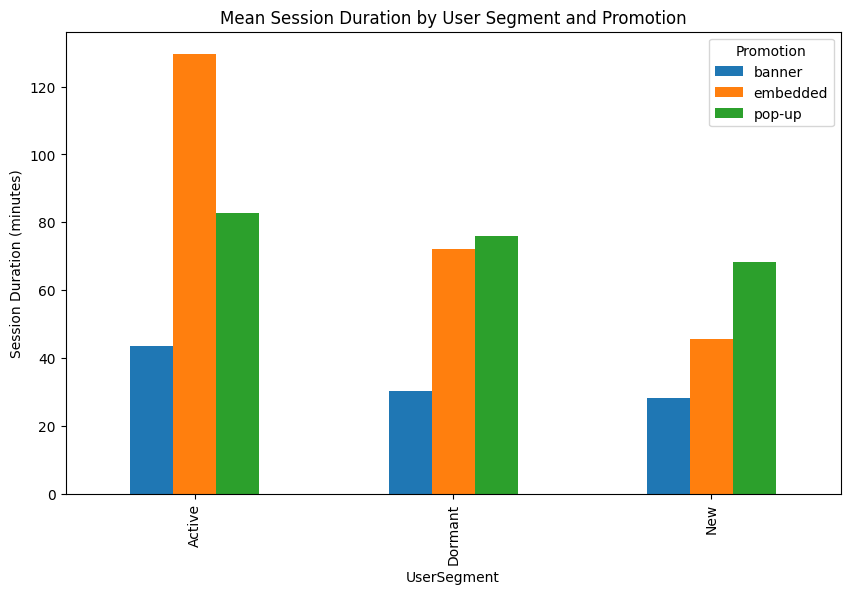

In [121]:
mean_duration = df.groupby(['UserSegment', 'Promotion'])['SessionDuration'].mean().unstack()
mean_duration.plot(kind='bar', figsize=(10, 6))
plt.title("Mean Session Duration by User Segment and Promotion")
plt.ylabel("Session Duration (minutes)")
plt.show()

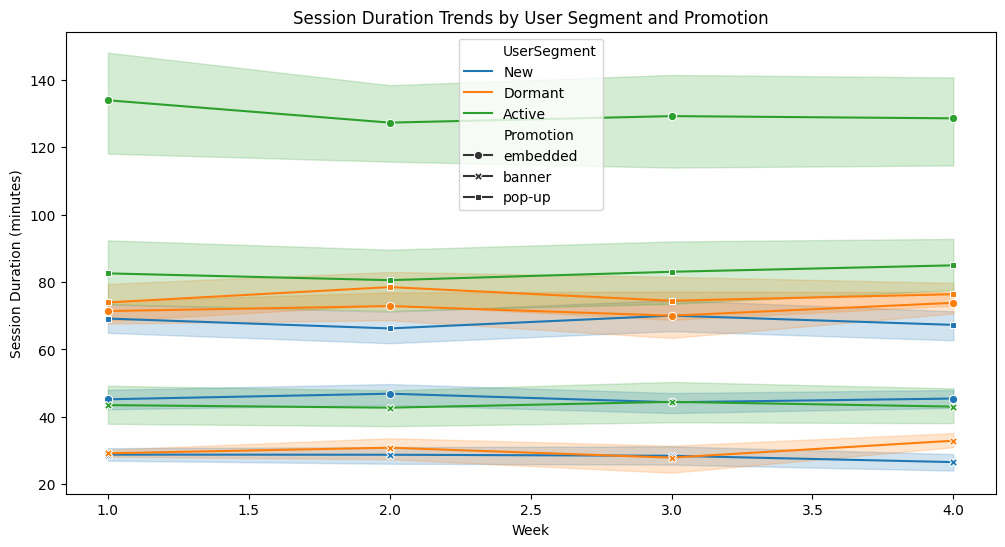

In [126]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='week', y='SessionDuration', hue='UserSegment', style='Promotion', markers=True, dashes=False)
plt.title("Session Duration Trends by User Segment and Promotion")
plt.xlabel("Week")
plt.ylabel("Session Duration (minutes)")
plt.show()
